# Reinforcement Learning Solution to the Towers of Hanoi Puzzle

### Vignesh M. Pagadala

## Summary
In this Notebook, we shall try to solve the 3-peg, 3-disk, Towers of Hanoi puzzle using Reinforcement Learning. To do this, we implement the following functions:
1. printState
2. validMoves
3. makeMove
4. trainQ
5. testQ
6. stateMoveTuple
7. isGoalState
8. epsilonGreedy

## Reinforcement Learning - Overview
In any AI problem, it is required of us to choose an action for which the result is optimal, i.e., we need to choose the best possible action from a set of actions. In order to do so, we need a value which can represent the future outcome of the state of the problem. Once we somehow obtain these values, a multi-step decision problem can be broken down into a single-step one (with multiple values associated with each action, it becomes possible to pick out the 'best' action, and get to the optimal solution state). 
For this, each (state, action) pair in the problem state-space can be associated with a 'value'. We define a 'reinforcement' as the step-cost to get from one state to another. The value for each (state, action) can be calculated as the sum of all the reinforcements down a certain path from that state till the goal state. 

The question arises now as to how we can synthesize these values. We do this by 'learning' from many example games/ problem-runs, from lots of tuples of the form (st,at,rt+1,st+1,at+1st,at,rt+1,st+1,at+1) (SARSA). We shall look into the implementation of this below.

## Implementation

### 1. printState
This function takes the state as a list and prints out the state of the Towers of Hanoi puzzle in a neat, readable format.

In [118]:
# Function to represent the state (of the pegs)
from copy import deepcopy
def printState(state):
    if state == 'No goal found.':
        return 'No goal found'
    # Make copy of state
    statenew = deepcopy(state)
    # Iterate through statenew and insert blanks in any position without a peg.
    for i in statenew:
        if len(i) == 0:
            i.insert(0, ' ')
            i.insert(0, ' ')
            i.insert(0, ' ')
        elif len(i) == 1:
            i.insert(0, ' ')
            i.insert(0, ' ')
        elif len(i) == 2:
            i.insert(0, ' ')
    # Loop through a transpose of 'state' and print out the values neatly.
    for i in list(zip(*statenew)):
        for j in i:
            print(j, end=' ')
        print()
    print('-----')

### 2. validMoves
This function takes in the *state* list as a parameter and returns all the valid moves which can be done from that state. These moves are returned as a list of moves, where each move is represented as a list of two elements of the form [source_peg, destination_peg], which implies that, the topmost disk from source_peg is transferred to the topmost position of destination_peg.

In [119]:
# Function which returns valid moves from a state, as a list.
def validMoves(state):
    # Initialize empty list to append valid moves to.
    valid = []
    # Loop through each peg.
    for i in range(3):
        # If peg is empty, ignore it and proceed to next peg.
        if state[i] == []:
            continue
        # Loop through each peg again.
        for j in range(3):
            # If we're not comparing the same pegs.
            if state[i] != state[j]:
                # Check if j is empty. If yes, then insert [i,j].
                if len(state[j]) == 0:
                    valid.append([i+1,j+1])
                # Else, check if disc in peg j is greater than disc in peg i. If yes, then insert.
                else:
                    if state[j][0] > state[i][0]:
                        valid.append([i+1,j+1])
    return valid

### 3. makeMove
This function takes two parameters, *state* and *move*, which are lists which represent the state of the puzzle and a move. It then applies the specifed move onto *state* and returns the new state which we get after this operation. 

In [120]:
# Function to apply a move to a state and return the new state.
def makeMove(state, move):
    if move != None:
        state2 = deepcopy(state)
        # Get the pegs from and to which the moves are to be done.
        source = move[0]
        dest = move[1]
        # Get the disk from source
        disk = state2[source - 1][0]
        # Remove from source
        state2[source-1].remove(disk)
        # Move disk to destination
        state2[dest - 1].insert(0, disk)
        return state2

### 4. isGoalState
Check whether the state specified is a goal state or not.

In [121]:
# Function to check if the goal state has been reached.
def isGoalState(state):
    if state == [[], [], [1,2,3]]:
        return True
    else:
        return False

### 5. stateMoveTuple
Implemented for the purpose of converting a list of lists to tuple of tuples. Enables us to make use of (state, action) pairs as keys in the Q dictionary.

In [122]:
# Function which converts lists to tuples.
def stateMoveTuple(state, move):
    stateTuple = tuple(tuple(x) for x in state)
    moveTuple = tuple(move)
    stateMoveTuple = (stateTuple, moveTuple)
    return stateMoveTuple

### 6. epsilonGreedy
This function is used to enable the algorithm to slowly transition from choosing totally random actions to a more directed approach where, the action which is considered to be the best move from that state is taken. For doing this, a parameter *epsilon* is decayed gradually from 1. 

In [123]:
import random
# Epsilon Greedy
def epsilonGreedy(epsilon, Q, state):
    # Get all the valid moves from state.
    valid = validMoves(state)
    qlist = []
    # If choosing random action.
    if np.random.uniform() < epsilon:
        # Random Move
        return random.choice(valid)
    # Greedy approach.
    else:
        # Greedy Move - get action for which the Q value is maximum.
        # Get Q values for all (state, move) pairs and store in a list.
        for move in valid:
            smt = stateMoveTuple(state, move)
            Qval = Q.get(smt, -1) # Assign -1 if not in tuple (default Q value)
            qlist.append((Qval, move))
        # Choose move with maximum value of Q.
        maxMove = max(qlist, key=lambda x:x[0])
        return maxMove[1]

## 7. trainQ
This function is used to update the Q values of various (state, action) pairs in the Q table with temporal-difference updates, by playing numerous games. It takes in the following parameters:
1. nRepetitions: The number of games to play.
2. learningRate: Determines the level to which a new update overrides an older one.
3. epsilonDecayFactor: The parameter based on which epsilon is decayed.
4. validMovesF: Function which returns all valid moves from a state.
5. makeMoveF: Function which applies a given move onto a given state.

Initially the default value of each (state, action) tuple in the Q table is considered to be -1. Games are played *nRepetitions* times by this function, each time the Q table being updated. After all games are played, the  Q dictionary and the number of steps taken to reach the goal for each game is returned.

In this implementation, we use temporal-difference updates to update the Q values. This is done as follows:
1. We have $s_t$, $a_t$, $r_{t+1}$, $s_{t+1}$, and $a_{t+1}$. How do we use these to update the values?
2. The Q value for $s_t$ and $a_t$ are updated using the temporal difference error <br>
Q(s_t,a_t) = Q(s_t,a_t) + \rho (r_{t+1} + Q(s_{t+1},a_{t+1}) - Q(s_t,a_t))
3. The final goal step should be updated differently. Here, since we know that the final step will always lead to the goal, we can do 
Q(s_t,a_t) = -1
4. If the goal is reached, we do 3 and start once again from the start state.
5. If goal hasn't been reached, then we choose an action using the epsilonGreedy function and get to a new state using this action (after updating Q).

In [124]:
# Function for training Q for Towers of Hanoi puzzle.

import numpy as np
def trainQ(nRepetitions, learningRate, epsilonDecayFactor, validMovesF, makeMoveF):
    # Initialize epsilon to 1, since we'll be decayign from 1.
    epsilon = 1.0
    # Initialize empty dictionary for the Q table. The Q table will be a dictionary with the as a tuple of the form:
    # (state, move). 'state' will be a tuple of tuples representing the state of the puzzle. For eg. ((1,2,3),(),())
    # would imply that all three disks are in the first peg. 'move' will be tuple with two elements, the source peg, and
    # the destination peg of the form (source, destination).
    Q = {}
    # List to keep track of steps taken to reach goal for each game played.
    stepsToGoal = []
    # Itearate nRepetitions times, to play as many games.
    for nGames in range(nRepetitions):
        # Decay epsilon to slowly change behaviour such that it stops selecting random moves and goes for a more greedy
        # approach. 
        epsilon *= epsilonDecayFactor
        # Initialize the start state (check if 3-disk puzzle or 4-disk)
        s = [[1,2,3], [], []]
        done = False
        step = 0
        # Play a game till solution occurs.
        while not done:        
            step += 1
            # Choose a move using epsilonGreedy function.
            move = epsilonGreedy(epsilon, Q, s)
            # Apply the move on a copy of state.
            sNew = deepcopy(s)
            sNew = makeMoveF(sNew, move)
            # If this (state, move) is not yet updated in the Q table, the default value is -1.
            if stateMoveTuple(s, move) not in Q:
                Q[stateMoveTuple(s, move)] = -1 
            # If the goal state is reached, then update Q(s, move) = -1 and break game (inner loop).
            if isGoalState(sNew):
                Q[stateMoveTuple(s, move)] = -1
                done = True
            else:
                # If the current step isn't the first step, then update Q value. 
                if step > 1:
                    Q[stateMoveTuple(sOld,moveOld)] += learningRate * (-1 + Q[stateMoveTuple(s,move)] - Q[stateMoveTuple(sOld,moveOld)])
                # Update the current state and move to these variables so that we can use them in the next iteration.
                sOld, moveOld = s, move 
                # Update state to the new state, which we have obtained by performing the move.
                s = sNew
        # Append the number of steps taken to stepsToGoal list.
        stepsToGoal.append(step)
    return Q, stepsToGoal

## 8. testQ
The testQ function uses the updated Q table to find the most optimal solution path from the start state to the goal. The following parameters are used:
1. Q: The Q table which is represented as a dictionary.
2. maxSteps: The maximum number of steps to take to finish the game.
3. validMovesF: A function which takes in a state and returns all the valid moves from that state.
4. makeMoveF: This function takes a state and a move and applies the specified move onto the state, and returns the new state.

It returns the final solution path to get to the goal.

It starts off from the initial state of the Towers of Hanoi, with all disks on the first peg. Then, it looks up the Q table (which has been updated already) for the moves from this state, and selects the move with the maximum Q value (which is the most optimal move). This move is then applied on the state to get to a new state and this process is repeated till we get to the goal. The final path returned is correct and optimal.

In [125]:
# Function testQ - used to find the optimal path.
def testQ(Q, maxSteps, validMovesF, makeMoveF):
    path = []
    # Initialize the start state with all disks on peg 1 (if 4-disk puzzle, then 4).
    s = [[1,2,3], [], []]
    # Append this start state to path list.
    path.append(s)
    steps = 0
    # Maintain a variable 'flag' to check if goal has been reached.
    flag = 0
    # Loop till maximu number of steps allowed.
    while steps < maxSteps:        
        # Choose greedy move (epsilonGreedy will always select the greedy move here since epsilon is specified as -1).
        move = epsilonGreedy(-1, Q, s)
        # Apply the move on the state.
        s = makeMoveF(s, move)
        # Append to path list.
        path.append(s)
        # If the goal state is reached, break out.
        if isGoalState(s):
            flag = 1
            break
        steps += 1
    # If no goal found within steps specified.
    if flag == 0:
        return "No goal found."
    return path

# Examples

In [126]:
state = [[1, 2, 3], [], []]
printState(state)

1     
2     
3     
-----


In [127]:
move =[1, 2]

stateMoveTuple(state, move)

(((1, 2, 3), (), ()), (1, 2))

In [128]:
newstate = makeMove(state, move)
newstate

[[2, 3], [1], []]

In [129]:
printState(newstate)

      
2     
3 1   
-----


In [130]:
Q, stepsToGoal = trainQ(50, 0.5, 0.7, validMoves, makeMove)

In [131]:
print(stepsToGoal)

[110, 34, 108, 23, 12, 44, 13, 11, 28, 15, 30, 7, 10, 12, 14, 8, 9, 30, 7, 11, 10, 7, 10, 30, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]


Let's plot this.

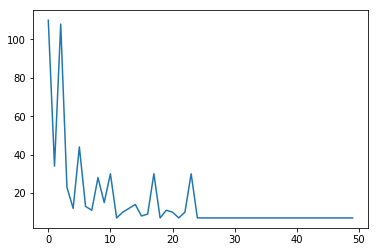

In [132]:
import matplotlib.pyplot as plt
plt.plot(stepsToGoal)
plt.show()

In [133]:
path = testQ(Q, 20, validMoves, makeMove)

In [134]:
path

[[[1, 2, 3], [], []],
 [[2, 3], [], [1]],
 [[3], [2], [1]],
 [[3], [1, 2], []],
 [[], [1, 2], [3]],
 [[1], [2], [3]],
 [[1], [], [2, 3]],
 [[], [], [1, 2, 3]]]

In [135]:
for s in path:
    printState(s)
    print()

1     
2     
3     
-----

      
2     
3   1 
-----

      
      
3 2 1 
-----

      
  1   
3 2   
-----

      
  1   
  2 3 
-----

      
      
1 2 3 
-----

      
    2 
1   3 
-----

    1 
    2 
    3 
-----



## More Examples

In [206]:
Q, stepsToGoal = trainQ(100, 0.1, 0.7, validMoves, makeMove)

In [207]:
print(stepsToGoal)

[145, 106, 97, 47, 85, 52, 86, 23, 19, 86, 21, 12, 83, 33, 18, 27, 53, 18, 49, 18, 17, 24, 41, 16, 27, 12, 40, 16, 26, 47, 14, 38, 10, 21, 17, 15, 28, 16, 33, 9, 19, 13, 9, 14, 54, 16, 24, 8, 7, 11, 9, 23, 21, 9, 11, 32, 8, 9, 27, 17, 11, 10, 14, 10, 10, 7, 15, 7, 18, 46, 13, 7, 9, 8, 22, 9, 7, 12, 9, 10, 10, 10, 7, 9, 7, 36, 22, 8, 7, 7, 11, 7, 21, 7, 7, 9, 9, 30, 7, 7]


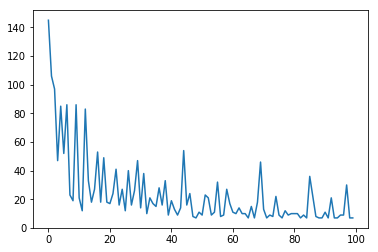

In [208]:
plt.plot(stepsToGoal)
plt.show()

In [209]:
p = testQ(Q, 20, validMoves, makeMove)

In [210]:
for s in p:
    printState(s)

1     
2     
3     
-----
      
2     
3 1   
-----
      
2     
3   1 
-----
      
      
3 2 1 
-----
      
  1   
3 2   
-----
      
  1   
  2 3 
-----
      
      
1 2 3 
-----
      
    2 
1   3 
-----
    1 
    2 
    3 
-----


Let's encourage more random move-selections by using epsilon decay factor = 1 

In [211]:
Q, stepsToGoal = trainQ(100, 0.5, 1, validMoves, makeMove)

In [212]:
print(stepsToGoal)

[16, 37, 59, 23, 206, 72, 250, 29, 47, 15, 87, 144, 474, 15, 40, 26, 94, 146, 21, 236, 162, 27, 264, 82, 169, 128, 46, 30, 13, 40, 24, 55, 48, 101, 59, 176, 112, 73, 396, 37, 80, 203, 252, 119, 292, 68, 163, 110, 83, 49, 87, 67, 64, 18, 42, 264, 51, 388, 121, 53, 106, 314, 34, 792, 82, 80, 47, 15, 89, 323, 106, 211, 499, 57, 48, 82, 72, 46, 239, 61, 13, 316, 163, 636, 16, 361, 17, 144, 195, 307, 47, 211, 9, 311, 78, 17, 159, 66, 87, 31]


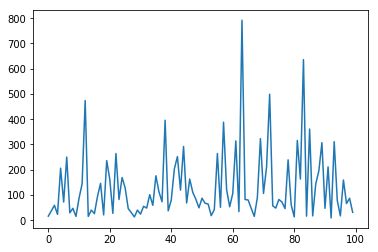

In [213]:
plt.plot(stepsToGoal)
plt.show()

As expected, more randomness implies that the algorithms spends more moves searching. Now let's try a more greedy approach (with epsilon decay factor of 0).

In [214]:
Q, stepsToGoal = trainQ(100, 0.5, 0, validMoves, makeMove)

In [215]:
print(stepsToGoal)

[66, 43, 75, 30, 52, 26, 45, 24, 15, 26, 12, 21, 7, 36, 7, 10, 7, 9, 7, 41, 9, 10, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]


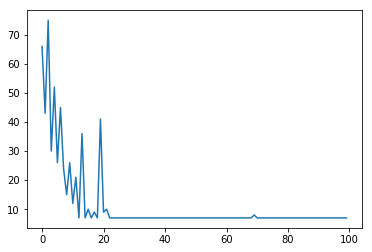

In [216]:
plt.plot(stepsToGoal)
plt.show()

It makes sense that there seem to be lesser number of moves on average. This is because, it tends to choose the most optimal move every time with a decay factor of 0.

## Grader Result

In [144]:
%run -i A5grader.py


Testing validMoves([[1], [2], [3]])

--- 10/10 points. Correctly returned [[1, 2], [1, 3], [2, 3]]

Testing validMoves([[], [], [1, 2, 3]])

--- 10/10 points. Correctly returned [[3, 1], [3, 2]]

Testing makeMove([[], [], [1, 2, 3]], [3, 2])

--- 10/10 points. Correctly returned [[], [1], [2, 3]]

Testing makeMove([[2], [3], [1]], [1, 2])

--- 10/10 points. Correctly returned [[], [2, 3], [1]]

Testing   Q, steps = trainQ(1000, 0.5, 0.7, validMoves, makeMove).

--- 10/10 points. Q dictionary has correct number of entries.

--- 10/10 points. The mean of the number of steps is 7.404 which is correct.

Testing   path = testQ(Q, 20, validMoves, makeMove).

--- 20/20 points. Correctly returns path of length 8, less than 10.

C:\Users\Vignesh\Documents\Colorado State University\Courses\CS440 - Introduction to Artificial Intelligence - Chuck Anderson\Assignments Execution Grade is 80/80

 Remaining 20 points will be based on your text describing the trainQ and test! functions.

C:\Users\Vign

## Extra Credit Problem

## Solving the 4-disk, 3-peg Tower of Hanoi.

To do this, we define the following functions. We tweak the functions used above a bit to get it to work for a 4-disk, 3-peg Tower of Hanoi.
1. printState_4disk
2. validMoves_4disk
3. makeMove_4disk
4. isGoalState_4disk
5. epsilonGreedy_4disk
6. trainQ_4disk
7. testQ_4disk

### 1. printState_4disk
This function prints out the state in a readable format.

In [145]:
# Function to represent the state (of the pegs)
# state = [[1,2,3,4], [], []]
from copy import deepcopy
def printState_4disk(state):
    if state == "No goal found.":
        return "No goal found."
    statenew = deepcopy(state)
    for i in statenew:
        if len(i) == 0:
            i.insert(0, ' ')
            i.insert(0, ' ')
            i.insert(0, ' ')
            i.insert(0, ' ')
        elif len(i) == 1:
            i.insert(0, ' ')
            i.insert(0, ' ')
            i.insert(0, ' ')
        elif len(i) == 2:
            i.insert(0, ' ')
            i.insert(0, ' ')
        elif len(i) == 3:
            i.insert(0, ' ')

    for i in list(zip(*statenew)):
        for j in i:
            print(j, end=' ')
        print()
    print('-----')

### 2. validMoves_4disk
Takes in state and returns all possible moves from this state.

In [146]:
# Function which returns valid moves from a state
def validMoves_4disk(state):
    valid = []
    for i in range(3):
        if state[i] == []:
            continue
        for j in range(3):
            if state[i] != state[j]:
                # Check if j is empty. If yes, then insert [i,j].
                if len(state[j]) == 0:
                    valid.append([i+1,j+1])
                # Else, check if disc in peg j is greater than disc in peg i. If yes, then insert.
                else:
                    if state[j][0] > state[i][0]:
                        valid.append([i+1,j+1])
    return valid

### 3. makeMove_4disk
Takes in a state and an action and applies the action to the state. Returns the new state.

In [147]:
# Function to apply a move to a state and return the new state.
def makeMove_4disk(state, move):
    if move != None:
        state2 = deepcopy(state)
        # Get the pegs from and to which the moves are to be done.
        source = move[0]
        dest = move[1]
        # Get the disk from source
        disk = state2[source - 1][0]
        # Remove from source
        state2[source-1].remove(disk)
        # Move disk to destination
        state2[dest - 1].insert(0, disk)
        return state2

### 4. isGoalState_4disk
Checks if given state is the goal state.

In [148]:
# Function to check if the goal state has been reached.
def isGoalState_4disk(state):
    if state == [[], [], [1,2,3,4]]:
        return True
    else:
        return False

### 5. epsilonGreedy_4disk
Used to gradually change behaviour of algorithm from choosing rando moves to a greedy approach.

In [149]:
# Epsilon Greedy
def epsilonGreedy_4disk(epsilon, Q, state):
    valid = validMoves_4disk(state)
    qlist = []
    if np.random.uniform() < epsilon:
            return random.choice(valid)
    else:
        # Greedy Move - get action for which the Q value is maximum.
        # Get Q values for all (state, move) pairs and store in a list.
        for move in valid:
            smt = stateMoveTuple(state, move)
            Qval = Q.get(smt, -1)
            qlist.append((Qval, move))
        maxMove = max(qlist, key=lambda x:x[0])
        return maxMove[1]

### 6. trainQ_4disk
Same as the trainQ function described above, but modified to solve the 4-disk puzzle.

In [150]:
# Function for training Q for Towers of Hanoi.
def trainQ_4disk(nRepetitions, learningRate, epsilonDecayFactor, validMovesF, makeMoveF):
    epsilon = 1.0
    Q = {}
    stepsToGoal = []
    for nGames in range(nRepetitions):
        # Decay epsilon
        epsilon *= epsilonDecayFactor

        # Start state for ToH
        s = [[1,2,3,4], [], []]

        # Play a game till solution occurs for ToH.
        done = False
        step = 0
        while not done:        
            step += 1

            # Choose a move.
            move = epsilonGreedy_4disk(epsilon, Q, s)

            # Apply the move on a copy of state.
            sNew = deepcopy(s)
            sNew = makeMoveF(sNew, move)

            if stateMoveTuple(s, move) not in Q:
                Q[stateMoveTuple(s, move)] = -1  # initial Q value for new board,move

            # If the goal state is reached, then update Q(s, move) += rho*(0 - Q(s, move)) and break game (inner loop).

            if isGoalState_4disk(sNew):
                Q[stateMoveTuple(s, move)] = -1
                done = True

            else:
                if step > 1:
                    Q[stateMoveTuple(sOld,moveOld)] += learningRate * (-1 + Q[stateMoveTuple(s,move)] - Q[stateMoveTuple(sOld,moveOld)])
                sOld, moveOld = s, move # remember board and move to Q(board,move) can be updated after next steps
                s = sNew
        stepsToGoal.append(step)

    return Q, stepsToGoal

### 7. testQ_4disk
Uses the updated Q table and finds optimal solution path.

In [151]:
def testQ_4disk(Q, maxSteps, validMovesF, makeMoveF):
    path = []
    s = [[1,2,3,4], [], []]
    path.append(s)
    print()
    steps = 0
    flag = 0
    while steps < maxSteps:        
        # Choose greedy move.
        move = epsilonGreedy_4disk(-1, Q, s)

        # Apply the move on the state.
        s = makeMoveF(s, move)
        path.append(s)

        # If the goal state is reached.
        if isGoalState_4disk(s):
            flag = 1
            break
        steps += 1
    if flag == 0:
        return "No goal found."
    return path

Now, let's try solving the 4-disk Tower of Hanoi using different values for number of repetitions, learning rate and epsilon decay factor.

Number of games: 100
Learning rate: 0.5
Epsilon decay: 0.7

In [152]:
Q, steps = trainQ_4disk(100, 0.5, 0.7, validMoves_4disk, makeMove_4disk)

In [153]:
path = testQ_4disk(Q, 20, validMoves_4disk, makeMove_4disk)

In [154]:
print(path)

[[[1, 2, 3, 4], [], []], [[2, 3, 4], [1], []], [[3, 4], [1], [2]], [[3, 4], [], [1, 2]], [[4], [3], [1, 2]], [[1, 4], [3], [2]], [[1, 4], [2, 3], []], [[4], [1, 2, 3], []], [[], [1, 2, 3], [4]], [[], [2, 3], [1, 4]], [[2], [3], [1, 4]], [[1, 2], [3], [4]], [[1, 2], [], [3, 4]], [[2], [1], [3, 4]], [[], [1], [2, 3, 4]], [[], [], [1, 2, 3, 4]]]


In [166]:
print(steps)

[569, 294, 184, 61, 158, 37, 136, 197, 64, 132, 45, 61, 59, 157, 36, 109, 135, 15, 45, 42, 117, 51, 39, 21, 36, 128, 46, 23, 71, 36, 30, 43, 54, 63, 18, 27, 85, 115, 21, 27, 15, 17, 84, 17, 38, 25, 19, 19, 16, 24, 15, 72, 15, 15, 70, 18, 15, 16, 19, 32, 18, 15, 15, 15, 15, 15, 15, 16, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]


In [156]:
for s in path:
    printState_4disk(s)

1     
2     
3     
4     
-----
      
2     
3     
4 1   
-----
      
      
3     
4 1 2 
-----
      
      
3   1 
4   2 
-----
      
      
    1 
4 3 2 
-----
      
      
1     
4 3 2 
-----
      
      
1 2   
4 3   
-----
      
  1   
  2   
4 3   
-----
      
  1   
  2   
  3 4 
-----
      
      
  2 1 
  3 4 
-----
      
      
    1 
2 3 4 
-----
      
      
1     
2 3 4 
-----
      
      
1   3 
2   4 
-----
      
      
    3 
2 1 4 
-----
      
    2 
    3 
  1 4 
-----
    1 
    2 
    3 
    4 
-----


Number of games: 100
Learning rate: 0.1
Epsilon decay: 0.7

In [167]:
Q2, steps2 = trainQ_4disk(1000, 0.05, 0.7, validMoves_4disk, makeMove_4disk)

In [168]:
path = testQ_4disk(Q2, 20, validMoves_4disk, makeMove_4disk)

In [169]:
print(path)

[[[1, 2, 3, 4], [], []], [[2, 3, 4], [1], []], [[3, 4], [1], [2]], [[3, 4], [], [1, 2]], [[4], [3], [1, 2]], [[1, 4], [3], [2]], [[1, 4], [2, 3], []], [[4], [1, 2, 3], []], [[], [1, 2, 3], [4]], [[], [2, 3], [1, 4]], [[2], [3], [1, 4]], [[1, 2], [3], [4]], [[1, 2], [], [3, 4]], [[2], [1], [3, 4]], [[], [1], [2, 3, 4]], [[], [], [1, 2, 3, 4]]]


In [170]:
print(steps2)

[229, 299, 572, 880, 301, 472, 255, 577, 88, 542, 160, 148, 585, 113, 254, 133, 497, 77, 84, 351, 195, 94, 224, 294, 91, 270, 164, 394, 179, 144, 147, 124, 54, 301, 112, 78, 350, 118, 133, 176, 103, 111, 88, 255, 91, 299, 144, 132, 57, 93, 75, 214, 197, 62, 130, 82, 201, 71, 176, 81, 53, 200, 62, 251, 80, 84, 116, 191, 61, 38, 91, 243, 86, 229, 26, 79, 176, 56, 77, 81, 60, 78, 294, 57, 104, 70, 92, 48, 69, 250, 64, 70, 66, 55, 194, 67, 97, 42, 206, 105, 60, 82, 67, 98, 51, 171, 66, 42, 65, 177, 39, 248, 24, 43, 61, 54, 72, 92, 43, 82, 131, 41, 141, 44, 129, 40, 62, 40, 83, 189, 63, 142, 27, 40, 86, 136, 33, 146, 39, 41, 37, 71, 65, 113, 22, 107, 34, 83, 114, 82, 54, 47, 125, 30, 112, 26, 89, 25, 28, 147, 63, 50, 184, 29, 64, 29, 84, 60, 37, 28, 141, 145, 39, 22, 46, 33, 40, 97, 72, 62, 22, 97, 28, 160, 43, 25, 69, 49, 73, 39, 29, 135, 55, 19, 136, 66, 29, 44, 27, 53, 33, 130, 41, 24, 181, 31, 46, 88, 17, 41, 110, 22, 40, 30, 49, 24, 135, 23, 74, 38, 26, 34, 57, 73, 23, 30, 112, 28, 21,

In [161]:
for s in path:
    printState_4disk(s)

1     
2     
3     
4     
-----
      
2     
3     
4 1   
-----
      
      
3     
4 1 2 
-----
      
      
3   1 
4   2 
-----
      
      
    1 
4 3 2 
-----
      
      
1     
4 3 2 
-----
      
      
1 2   
4 3   
-----
      
  1   
  2   
4 3   
-----
      
  1   
  2   
  3 4 
-----
      
      
  2 1 
  3 4 
-----
      
      
    1 
2 3 4 
-----
      
      
1     
2 3 4 
-----
      
      
1   3 
2   4 
-----
      
      
    3 
2 1 4 
-----
      
    2 
    3 
  1 4 
-----
    1 
    2 
    3 
    4 
-----


Number of games: 20
Learning rate: 0.5
Epsilon decay: 0.7

In [172]:
Q2, steps2 = trainQ_4disk(20, 0.05, 0.7, validMoves_4disk, makeMove_4disk)

In [173]:
print(steps2)

[321, 617, 272, 744, 88, 387, 677, 238, 128, 348, 374, 197, 419, 66, 409, 187, 429, 149, 166, 273]


In [174]:
Q2, steps2 = trainQ_4disk(200, 0.05, 0.7, validMoves_4disk, makeMove_4disk)

In [176]:
print(steps2)

[185, 647, 640, 394, 288, 420, 551, 464, 111, 529, 74, 218, 322, 338, 201, 217, 265, 138, 509, 65, 269, 307, 51, 118, 258, 209, 97, 364, 105, 342, 82, 202, 106, 189, 234, 102, 269, 81, 129, 126, 242, 82, 92, 210, 210, 61, 218, 73, 192, 146, 62, 71, 302, 90, 283, 74, 25, 81, 174, 74, 117, 84, 224, 58, 46, 185, 85, 295, 48, 89, 127, 28, 159, 78, 212, 107, 172, 23, 62, 90, 156, 55, 146, 82, 145, 77, 84, 147, 61, 69, 153, 33, 100, 220, 22, 173, 43, 52, 105, 45, 207, 109, 27, 71, 60, 51, 158, 51, 95, 107, 28, 143, 81, 109, 60, 32, 160, 64, 44, 240, 45, 124, 35, 44, 62, 33, 183, 74, 26, 157, 49, 40, 96, 62, 39, 58, 83, 160, 35, 49, 127, 76, 34, 70, 72, 49, 141, 25, 63, 190, 32, 44, 151, 39, 32, 46, 35, 90, 59, 197, 46, 23, 37, 134, 25, 64, 41, 114, 34, 46, 36, 26, 147, 72, 97, 41, 53, 50, 97, 44, 29, 163, 45, 39, 87, 36, 48, 25, 27, 104, 54, 51, 136, 47, 25, 28, 107, 65, 60, 22]


In [177]:
Q2, steps2 = trainQ_4disk(200, 0.5, 0.7, validMoves_4disk, makeMove_4disk)

In [178]:
print(steps2)

[448, 184, 368, 270, 281, 47, 133, 122, 70, 51, 111, 35, 127, 35, 47, 119, 195, 32, 77, 109, 34, 24, 61, 55, 21, 63, 33, 75, 39, 64, 39, 22, 101, 24, 27, 18, 32, 33, 20, 34, 46, 20, 18, 16, 100, 58, 15, 17, 19, 24, 15, 15, 46, 15, 17, 44, 88, 15, 15, 18, 15, 15, 16, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]


In [179]:
Q2, steps2 = trainQ_4disk(200, 0.1, 0.7, validMoves_4disk, makeMove_4disk)

In [180]:
print(steps2)

[939, 181, 465, 383, 274, 308, 345, 391, 139, 92, 280, 208, 131, 257, 115, 135, 284, 78, 93, 232, 170, 85, 157, 173, 140, 238, 75, 123, 121, 69, 87, 191, 99, 201, 121, 84, 175, 32, 85, 66, 187, 37, 140, 110, 103, 70, 59, 194, 141, 40, 99, 27, 181, 65, 119, 31, 46, 75, 157, 72, 23, 76, 59, 146, 38, 209, 41, 74, 77, 44, 146, 47, 40, 45, 179, 28, 60, 34, 25, 86, 45, 43, 67, 150, 44, 57, 85, 34, 63, 49, 130, 35, 128, 58, 27, 54, 99, 19, 67, 139, 27, 26, 37, 90, 34, 37, 48, 104, 86, 33, 44, 27, 35, 147, 25, 21, 48, 29, 30, 53, 52, 18, 75, 35, 193, 30, 25, 36, 39, 92, 30, 26, 23, 87, 26, 25, 22, 82, 39, 25, 106, 27, 21, 36, 101, 31, 27, 34, 15, 92, 31, 21, 72, 37, 19, 20, 48, 27, 120, 32, 27, 18, 28, 47, 39, 103, 19, 24, 18, 56, 25, 27, 32, 16, 62, 19, 21, 32, 19, 98, 20, 29, 19, 43, 28, 20, 25, 97, 126, 16, 18, 17, 49, 27, 19, 20, 26, 19, 65, 15]


In [201]:
Q2, steps2 = trainQ_4disk(100, 0.5, 0.7, validMoves_4disk, makeMove_4disk)

In [202]:
print(steps2)

[537, 470, 75, 251, 141, 90, 102, 48, 34, 169, 61, 51, 135, 85, 60, 26, 72, 78, 41, 91, 43, 40, 135, 26, 103, 27, 44, 96, 35, 100, 40, 26, 26, 106, 29, 18, 78, 53, 18, 19, 21, 18, 61, 25, 18, 44, 24, 17, 30, 15, 16, 76, 66, 15, 15, 19, 15, 16, 16, 17, 15, 15, 46, 15, 15, 15, 15, 15, 15, 15, 17, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]


100 games played, with a learning rate of 0.5 and decay of 0.7 seems to work well.